In [1]:
import pandas as pd
import numpy as np
import click
import logging
from pathlib import Path
import datetime as dt
import re
import os
from metpy import calc
from metpy.units import units
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)




C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [2]:
X = context.catalog.load("feature_names_WF1")

2020-10-09 10:58:01,515 - kedro.io.data_catalog - INFO - Loading data from `feature_names_WF1` (PickleDataSet)...


In [ ]:
input_filepath = "../data/raw/" 
output_filepath = "../data/interim/"

# Import raw data
X_train = import_data(input_filepath + 'X_train_raw.csv')
X_train['Time'] = pd.to_datetime(X_train['Time'], format='%d/%m/%Y %H:%M')
y_train = import_data(input_filepath + 'y_train_raw.csv')

# Wind farm list
WF_lst = X_train['WF'].unique()

# New columns that will be added to data sets
new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U','NWP2_V','NWP3_U',
        'NWP3_V','NWP3_T','NWP4_U','NWP4_V','NWP4_CLCT']

# Columns that need interpolating missing values
col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']

#for WF in WF_lst:
# Make a copy of the data to not losing its initial format
X_train_cpy = X_train.copy()
y_train_cpy = y_train.copy()

    
# Row selection by WF
X_train_cpy = X_train_cpy[X_train_cpy['WF'] == 'WF1']

# Save observations identification
ID_train = X_train_cpy['ID']

# Row selection for y_train
y_train_cpy = y_train_cpy.loc[ID_train.values - 1]

# Add new columns to X_train and X_test
add_new_cols(new_cols, X_train_cpy)

# Impute missing values
X_train_cpy = input_missing_values(X_train_cpy, X_train.columns[3:])
interpolate_missing_values(X_train_cpy, col_list, 'Time')

# Select the best NWP predictions for weather predictors
X_train_cpy['U'] = X_train_cpy.NWP1_U
X_train_cpy['V'] = X_train_cpy.NWP1_V
X_train_cpy['T'] = X_train_cpy.NWP3_T
X_train_cpy['CLCT'] = X_train_cpy.NWP4_CLCT

X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]

In [ ]:
X_train_cpy['Production'] = list(y_train_cpy['Production'])

# Calculate wind velocity module
X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)

In [ ]:
# Calculate wind velocity module
X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)

# Add 'Production' column
X_train_cpy['Production'] = list(y_train_cpy['Production'])

In [ ]:
X_train_cpy.head()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, 
                    cols=1, 
                    start_cell="top-left",
                    x_title='X',
                    y_title='Y')

fig.add_trace(go.Scatter(x=X_train_cpy['U'], y=X_train_cpy['T'], mode="markers", marker=dict(size=3)),
              row=1, col=1)


fig.update_layout(height=700, width=800)

fig.show()

X_train_cpy['CLCT'].hist()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
# Add 'Production' column
X_train_cpy['Production'] = list(y_train_cpy['Production'])

# Calculate wind velocity module
X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)

# Build data matrix
X1 = X_train_cpy['vel'].values.reshape(-1,1)
X2 = X_train_cpy['Production'].values.reshape(-1,1)
X = np.concatenate((X1,X2), axis=1)

# Using DBSCAN to find outliers
outlier_detection = DBSCAN(eps = 0.18, metric = "mahalanobis", algorithm = 'brute', min_samples = 20, n_jobs = -1)
clusters = outlier_detection.fit_predict(X)
outliers = np.where(clusters == -1)[0]

# Plot outliers
plt.scatter(*X.T, color='yellowgreen', marker='.', label='Inliers')
plt.scatter(*X[outliers].T, color='gold', marker='.', label='Outliers')
plt.legend(loc='lower right')
plt.xlabel("wind speed [m/s]")
plt.ylabel("wind power [MWh]")
plt.show()

In [ ]:
X_ = X_train_cpy[['vel','Production']]

In [ ]:
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve

def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 3, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 3, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.show()

In [ ]:
plot_flagged_pc(X_.vel, X_.Production, np.repeat('True', len(X_.vel)), 0.7)

In [ ]:
# top-curve stacked outliers
top_stacked = filters.window_range_flag(X_.Production, 0.97*X_.Production.max(), X_.Production.max(), X_.vel, 12.5, 2000.)

# sparse outliers
max_bin = 0.97*X_.Production.max()
sparse_outliers = filters.bin_filter(X_.Production, X_.vel, 0.05, X_.Production.std(), 'median', 0.2, max_bin, 'std', 'all')

# bottom-curve stacked outliers
bottom_stacked = filters.window_range_flag(X_.vel, 5.5, 40, X_.Production, 0.05, 2000.)

# deleting outliers
X_.vel = X_.vel[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
X_.Production = X_.Production[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
plot_flagged_pc(X_.vel, X_.Production, np.repeat('True', len(X_.vel)), 0.7)

In [ ]:
X_train_raw = context.catalog.load("X_train_raw")
y_train_raw = context.catalog.load("y_train_raw")

In [ ]:
from wind_power_forecasting.pipelines.data_engineering.nodes import *

In [50]:
%load_ext autoreload
%autoreload 2


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [51]:
%reload_ext autoreload

In [ ]:
X_train_WF1 = get_data_by_wf(X_train_raw,'WF1',y_train_raw)[0]
y_train_WF1 = get_data_by_wf(X_train_raw,'WF1',y_train_raw)[1]

In [ ]:
pd.DataFrame(y_train_WF1.to_numpy().reshape(-1))

In [ ]:
add_new_cols(ctx.params.get("new_cols"),X_train_WF1)

In [ ]:
X_train_WF1

In [ ]:
X_train_WF1_no_missings = input_missing_values(X_train_WF1,X_train_raw.columns[3:],ctx.params.get("cols_to_interpol"))

In [ ]:
X_train_WF1_nomissings_bestNWP = select_best_NWP_features(X_train_WF1_no_missings)

In [ ]:
X_train_WF1_nomissings_bestNWP.head()

In [ ]:
from wind_power_forecasting.nodes import data_exploration as dexp

In [ ]:
dexp.get_missing_percentage(X_train_WF1_nomissings_bestNWP)

In [ ]:
clean_outliers(X_train_WF1_nomissings_bestNWP,y_train_WF1,"WF1",ctx)

In [ ]:
X_train_WF1_nomissings_bestNWP_cleaned_noneg =  fix_negative_values(X_train_WF1_nomissings_bestNWP_cleaned)

In [ ]:
X_train_WF1_nomissings_bestNWP_cleaned.describe()

In [ ]:
sets = split_data_by_date(ctx.params.get("split_date"),X_train_WF1_nomissings_bestNWP_cleaned_noneg, y_train_WF1_cleaned)

In [ ]:
X_train_pped_WF1 = sets.get("X_train")
X_test_pped_WF1 = sets.get("X_test")
y_train_ppped_WF1 = sets.get("y_train")
y_test_pped_WF1 = sets.get("y_test")

In [ ]:
y_train_ppped_WF1

In [ ]:
y_train_ppped_WF1

In [ ]:
y = ctx.catalog.load("y_train_WF1")

In [ ]:
X

In [ ]:
y

In [ ]:
X = X_train_WF1_nomissings_bestNWP_cleaned_noneg
y = y_train_WF1_cleaned
X_test = X[X["Time"] > ctx.params.get("split_date")]
X_train = X[X["Time"] <= ctx.params.get("split_date")]
y_train = y[X_train.index]
y_test = y[X_test.index]

In [ ]:
y_train

In [ ]:
X_train.index

In [ ]:
for key, value in sets.items():
    print(key, value)

In [ ]:
sets.values()

In [ ]:
sets.keys

In [ ]:
sets.items()

In [ ]:
y_train_WF1

In [ ]:
dict = {'coche':1, 'camion':2}

In [ ]:
key, value = list(dict.items())
                               

In [ ]:
list(dict.keys())

In [ ]:
X_train_pped_WF1 = context.catalog.load("X_train_pped_WF1")
X_test_pped_WF1 = context.catalog.load("X_test_pped_WF1")
y_train_WF1 = context.catalog.load("y_train_WF1")
y_test_WF1 = context.catalog.load("y_test_WF1")

In [ ]:
y_test_WF1

In [ ]:
y_test_WF1.describe()

In [ ]:
tupla = (1,3,5)

In [ ]:
tupla

In [ ]:
predictions = context.catalog.load("predictions")

In [ ]:
import pandas as pd
import numpy as np
predictions = pd.Series(predictions, name="estimado")

In [ ]:
predictions

In [ ]:
y_test = context.catalog.load("y_test_WF1")

In [ ]:
y_test = y_test[0]

In [ ]:
y_test.rename("real",inplace=True)

In [ ]:
X_test = context.catalog.load("X_test_WF1")
X_test['Time'] = pd.to_datetime(X_test.Time)

In [ ]:
real_pred = pd.concat([y_test, predictions], axis=1)

In [ ]:
real_pred.set_index(X_test.Time, inplace=True)

In [ ]:
import plotly.express as px
import psutil
fig = px.line(data_frame=real_pred, x=real_pred.index, y=['real','estimado'], 
              labels={'Time':'Fecha','value':'Producción (MWh)'})

fig.write_image("./ts_predictions.png")

In [ ]:
print(real_pred.describe().to_latex())

In [ ]:
X_test.Time

In [ ]:
import plotly.graph_objects as go

fig.show()

In [2]:
import pandas as pd
import plotly.express as px

X_test = context.catalog.load("X_test_WF1")
y_test = context.catalog.load("y_test_WF1")
y_test = y_test[0]
y_test.rename("real",inplace=True)
predictions = context.catalog.load("predictions")
predictions = pd.Series(predictions, name="estimado")

2020-10-06 20:39:55,046 - kedro.io.data_catalog - INFO - Loading data from `X_test_WF1` (CSVDataSet)...
2020-10-06 20:39:55,123 - kedro.io.data_catalog - INFO - Loading data from `y_test_WF1` (CSVDataSet)...
2020-10-06 20:39:55,196 - kedro.io.data_catalog - INFO - Loading data from `predictions` (PickleDataSet)...


In [2]:
import pickle
filename = "../../data/06_models/WF1/KNN.pickle"
loaded_model = pickle.load(open(filename, 'rb'))

In [3]:
loaded_model

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Pipeline(steps=[('univariate_sel',
                 SelectKBest(k=1,
                             score_func=<function mutual_info_regression at 0x000002879BB97678>)),
                ('knn',
                 KNeighborsRegressor(algorithm='kd_tree', metric='cityblock',
                                     n_neighbors=29))])

In [ ]:
df['date']

In [1]:
import numpy as np

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [7]:
list(np.arange(1, 100 + 1, 5))

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]

In [8]:
from scipy.stats import uniform

In [11]:
r = uniform.rvs(size=20)

In [12]:
r

array([0.37761394, 0.83435291, 0.51466988, 0.0779286 , 0.41094902,
       0.64621377, 0.17794056, 0.99893925, 0.64383056, 0.24986919,
       0.19958852, 0.78336208, 0.72049298, 0.93935449, 0.52560264,
       0.20056865, 0.50990197, 0.42527607, 0.00615807, 0.95521543])

In [29]:
X_train_WF6 = context.catalog.load("X_train_expanded_WF6")

2020-10-10 13:33:52,553 - kedro.io.data_catalog - INFO - Loading data from `X_train_expanded_WF6` (PickleDataSet)...


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [30]:
X_train_WF6.head()

,ID,Time,U,V,T,CLCT,wspeed,wdir,wspeed_wdir,wspeed_T,wspeed_wdir_T
0,31142,2018-05-01 06:00:00,-1.408967,-7.668500,280.89,100.0,7.796864,10.411088,81.173836,2190.060998,22800.918849
1,31143,2018-05-01 07:00:00,-0.963266,-7.174133,280.55,100.0,7.238513,7.647326,55.355271,2030.764814,15529.921376
2,31144,2018-05-01 08:00:00,-0.517564,-6.679767,280.72,100.0,6.699788,4.430562,29.683823,1880.764409,8332.842802
3,31146,2018-05-01 10:00:00,-0.035885,-6.106633,282.01,100.0,6.106739,0.336693,2.056095,1722.161401,579.839303
4,31147,2018-05-01 11:00:00,0.000092,-6.027867,282.96,100.0,6.027867,359.999126,2170.026731,1705.645152,614030.763930


In [22]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pty
import re

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

In [6]:
corr = X_train_WF6.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,ID,U,V,T,CLCT,wspeed,wdir
ID,1.000000,0.016293,0.116785,-0.281399,-0.026142,0.149055,-0.080921
U,0.016293,1.000000,0.170263,-0.037214,0.128132,0.326220,0.640136
V,0.116785,0.170263,1.000000,0.067132,0.202143,-0.127549,0.002621
T,-0.281399,-0.037214,0.067132,1.000000,-0.283798,-0.115968,-0.046328
CLCT,-0.026142,0.128132,0.202143,-0.283798,1.000000,0.025182,0.078013
wspeed,0.149055,0.326220,-0.127549,-0.115968,0.025182,1.000000,0.196631
wdir,-0.080921,0.640136,0.002621,-0.046328,0.078013,0.196631,1.000000


In [16]:
from pandas_profiling import ProfileReport

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame(
    X_train_WF6,
    columns=["U","V","T","CLCT","wspeed","wdir"]
)

In [12]:
df.head()

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,U,V,T,CLCT,wspeed,wdir
0,-1.3603,-4.2357,281.85,98.045259,4.448772,17.804482
1,-1.5595,-4.8766,281.97,100.000000,5.119889,17.733885
2,-0.2236,-5.4330,281.85,99.945066,5.437599,2.356729
3,0.4828,-6.5738,281.39,100.000000,6.591505,355.799564
4,0.0730,-6.9169,280.89,100.000000,6.917285,359.395331


In [17]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [18]:
profile

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [59]:
df_eda_WF6 = context.catalog.load("df_WF6")

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2020-10-10 13:57:37,131 - kedro.io.data_catalog - INFO - Loading data from `df_WF6` (CSVDataSet)...


In [32]:
df_eda_WF6.head()

,NWP,fc_day,run,id,time,U,V,T,CLCT,production
0,1,D-2,00h,31137,01/05/2018 01:00,NaN,NaN,NaN,NaN,0.00
1,1,D-2,00h,31138,01/05/2018 02:00,NaN,NaN,NaN,NaN,0.00
2,1,D-2,00h,31139,01/05/2018 03:00,NaN,NaN,NaN,NaN,0.07
3,1,D-2,00h,31140,01/05/2018 04:00,NaN,NaN,NaN,NaN,0.37
4,1,D-2,00h,31141,01/05/2018 05:00,NaN,NaN,NaN,NaN,0.54


In [33]:
df_eda_WF6.loc[df_eda_WF6['NWP'] == 1, 'T'].describe()

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



count    183126.00000
mean        289.01200
std           8.85294
min         268.65000
25%         281.61000
50%         290.30000
75%         295.61000
max         310.46000
Name: T, dtype: float64

In [58]:
df_eda_WF6.loc[df_eda_WF6['NWP'] == 3, 'T'].describe()

count    62349.000000
mean       288.027804
std          7.625401
min        269.645111
25%        282.300018
50%        288.625488
75%        293.800018
max        306.517242
Name: T, dtype: float64

In [37]:
X_train_WF6['T'].describe()

count    3892.000000
mean      292.310766
std         6.239578
min       274.900000
25%       288.090000
50%       292.280000
75%       296.672500
max       309.850000
Name: T, dtype: float64

In [38]:
X_train_pped = context.catalog.load("X_train_pped_WF6")

2020-10-10 13:37:41,687 - kedro.io.data_catalog - INFO - Loading data from `X_train_pped_WF6` (PickleDataSet)...


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [39]:
X_train_pped

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([[-1.83180259,  0.74369704, -1.23855673, -0.9017188 ,  0.63749792,
        -0.91259585],
       [-1.88640439,  0.53529599, -1.31269637, -1.03714453,  0.43396159,
        -1.04660973],
       [-1.85910309,  0.33319791, -1.41857364, -1.23161339,  0.2410759 ,
        -1.23910494],
       ...,
       [-1.4721511 , -0.00794579,  1.024715  ,  0.90442675, -0.0695838 ,
         0.88050847],
       [-1.52673236, -0.1953527 ,  1.0346793 ,  0.84029664, -0.25445599,
         0.81561786],
       [-1.5893441 , -0.37809121,  1.04658856,  0.7742802 , -0.43503153,
         0.74877743]])

In [54]:
feature_names = context.catalog.load("feature_names_WF6")

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2020-10-10 13:56:17,100 - kedro.io.data_catalog - INFO - Loading data from `feature_names_WF6` (PickleDataSet)...


In [41]:
feature_names

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Index(['T', 'wspeed', 'wdir', 'wspeed_wdir', 'wspeed_T', 'wspeed_wdir_T'], dtype='object')

In [42]:
X_WF6_df = pd.DataFrame(X_train_pped, columns=feature_names)

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
X_WF6_df.head()

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,T,wspeed,wdir,wspeed_wdir,wspeed_T,wspeed_wdir_T
0,-1.831803,0.743697,-1.238557,-0.901719,0.637498,-0.912596
1,-1.886404,0.535296,-1.312696,-1.037145,0.433962,-1.046610
2,-1.859103,0.333198,-1.418574,-1.231613,0.241076,-1.239105
3,-1.651960,0.109468,-1.633814,-1.760996,0.035717,-1.802053
4,-1.499441,0.079608,1.047853,0.950551,0.014243,0.926035


In [47]:
X_train_pped = context.catalog.load("X_train_pped_WF6")

2020-10-10 13:54:23,149 - kedro.io.data_catalog - INFO - Loading data from `X_train_pped_WF6` (PickleDataSet)...


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [55]:
X_WF6_df = pd.DataFrame(X_train_pped, columns=feature_names)

In [56]:
X_WF6_df.head()

,T,CLCT,wspeed,wdir,hour,month
0,-1.831803,1.056593,0.743697,-1.238557,-0.694478,-1.549596
1,-1.886404,1.056593,0.535296,-1.312696,-0.533204,-1.549596
2,-1.859103,1.056593,0.333198,-1.418574,-0.377874,-1.549596
3,-1.651960,1.056593,0.109468,-1.633814,-0.081849,-1.549596
4,-1.499441,1.056593,0.079608,1.047853,0.060021,-1.549596


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<AxesSubplot:>

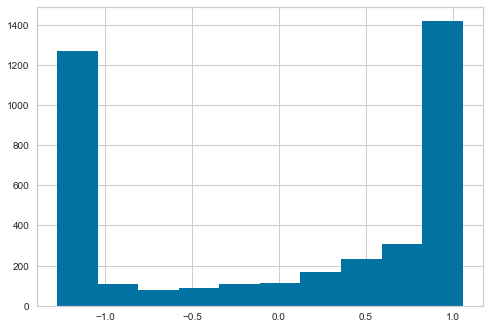

In [57]:
X_WF6_df["CLCT"].hist()

In [60]:
X_expanded = context.catalog.load("X_train_expanded_WF6")

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2020-10-10 13:58:07,727 - kedro.io.data_catalog - INFO - Loading data from `X_train_expanded_WF6` (PickleDataSet)...


In [61]:
X_expanded

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,ID,Time,U,V,T,CLCT,wspeed,wdir,hour,month
0,31142,2018-05-01 06:00:00,-1.408967,-7.668500,280.89,100.000000,7.796864,10.411088,6,5
1,31143,2018-05-01 07:00:00,-0.963266,-7.174133,280.55,100.000000,7.238513,7.647326,7,5
2,31144,2018-05-01 08:00:00,-0.517564,-6.679767,280.72,100.000000,6.699788,4.430562,8,5
3,31146,2018-05-01 10:00:00,-0.035885,-6.106633,282.01,100.000000,6.106739,0.336693,10,5
4,31147,2018-05-01 11:00:00,0.000092,-6.027867,282.96,100.000000,6.027867,359.999126,11,5
...,...,...,...,...,...,...,...,...,...,...
3887,35858,2018-11-13 19:00:00,0.465203,-5.733167,283.90,42.529713,5.752010,355.361049,19,11
3888,35859,2018-11-13 20:00:00,0.559951,-5.746533,283.48,40.649744,5.773750,354.434580,20,11
3889,35860,2018-11-13 21:00:00,0.654700,-5.759900,283.13,14.099759,5.796989,353.515300,21,11
3890,35861,2018-11-13 22:00:00,0.342382,-5.293767,282.79,22.666436,5.304827,356.299467,22,11


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<AxesSubplot:>

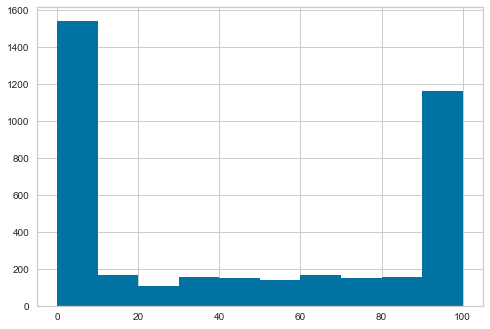

In [62]:
X_expanded['CLCT'].hist()

In [63]:
X_expanded.loc[X_expanded["CLCT"] <= 50, "CLCT"] = 0.0
X_expanded.loc[X_expanded["CLCT"] > 50, "CLCT"] = 1.0

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<AxesSubplot:>

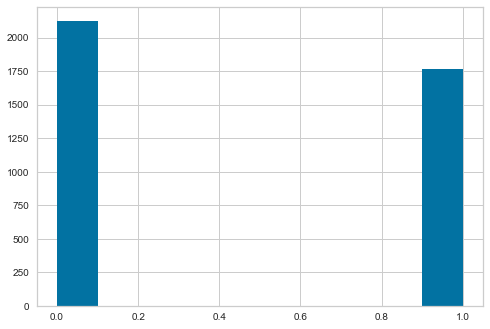

In [64]:
X_expanded['CLCT'].hist()

In [80]:
import numpy as np
np.arange(0, 101, 10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [95]:
min(2 * 1 + 3892 // 10, 400)

391

In [91]:
4000 // 10

400

In [94]:
context.catalog.load("X_train_pped_WF6").shape

2020-10-10 20:16:25,341 - kedro.io.data_catalog - INFO - Loading data from `X_train_pped_WF6` (PickleDataSet)...


(3892, 6)

In [3]:
context.catalog.load("y_train_raw")

2020-10-11 18:59:42,994 - kedro.io.data_catalog - INFO - Loading data from `y_train_raw` (CSVDataSet)...


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,ID,Production
0,1,0.02
1,2,0.07
2,3,0.22
3,4,0.39
4,5,0.41
...,...,...
37370,37371,0.04
37371,37372,0.33
37372,37373,0.13
37373,37374,0.01


In [6]:
context.catalog.load("X_test_pped_WF1")

2020-10-11 22:01:10,432 - kedro.io.data_catalog - INFO - Loading data from `X_test_pped_WF1` (PickleDataSet)...


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([[ 2.88670000e+02,  6.93284269e+01,  8.64092136e-01, ...,
        -3.79900000e-01,  2.24036787e+02, -1.09665733e+02],
       [ 2.88070000e+02,  7.00288374e+01,  1.14622314e+00, ...,
         4.40500000e-01,  3.04835674e+02,  1.26894835e+02],
       [ 2.87690000e+02,  7.29174587e+01,  1.66273048e+00, ...,
         7.99500000e-01,  4.19423251e+02,  2.30008155e+02],
       ...,
       [ 2.79390000e+02,  0.00000000e+00,  6.20292072e+00, ...,
         5.27650000e+00,  9.11118729e+02,  1.47420133e+03],
       [ 2.79200000e+02,  0.00000000e+00,  4.55214705e+00, ...,
         3.08680000e+00,  9.34119440e+02,  8.61834560e+02],
       [ 2.78900000e+02,  0.00000000e+00,  4.14213120e+00, ...,
         1.29710000e+00,  1.09713682e+03,  3.61761190e+02]])

In [7]:
context.catalog.load("X_test_expanded_WF1")

2020-10-11 22:01:17,234 - kedro.io.data_catalog - INFO - Loading data from `X_test_expanded_WF1` (PickleDataSet)...


,ID,Time,U,V,T,CLCT,wspeed,wdir,hour,month,...,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,wspeed_T,wspeed_wdirsin,wspeed_wdircos,wspeed_wdirsin_T,wspeed_wdircos_T
0,4727,2018-11-14 00:00:00,-0.7761,0.3799,288.67,69.328427,0.864092,116.081692,0,11,...,1.000000,-0.5,0.866025,0.898168,-0.439652,249.437477,0.7761,-0.3799,224.036787,-109.665733
1,4728,2018-11-14 01:00:00,-1.0582,-0.4405,288.07,70.028837,1.146223,67.399361,1,11,...,0.965926,-0.5,0.866025,0.923206,0.384306,330.192500,1.0582,0.4405,304.835674,126.894835
2,4729,2018-11-14 02:00:00,-1.4579,-0.7995,287.69,72.917459,1.662730,61.260010,2,11,...,0.866025,-0.5,0.866025,0.876811,0.480836,478.350933,1.4579,0.7995,419.423251,230.008155
3,4730,2018-11-14 03:00:00,-1.5464,-0.8585,287.85,68.550193,1.768721,60.962701,3,11,...,0.707107,-0.5,0.866025,0.874304,0.485379,509.126440,1.5464,0.8585,445.131240,247.119225
4,4731,2018-11-14 04:00:00,-1.5626,-0.4685,288.24,94.503532,1.631322,73.310175,4,11,...,0.500000,-0.5,0.866025,0.957874,0.287190,470.212213,1.5626,0.4685,450.403824,135.040440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,6234,2019-01-15 19:00:00,-1.9553,-8.0003,280.76,0.000000,8.235776,13.734046,19,1,...,0.258819,0.5,0.866025,0.237415,0.971408,2312.276331,1.9553,8.0003,548.970028,2246.164228
1061,6236,2019-01-15 21:00:00,-3.0983,-6.7763,279.73,0.000000,7.451020,24.571108,21,1,...,0.707107,0.5,0.866025,0.415822,0.909446,2084.273929,3.0983,6.7763,866.687459,1895.534399
1062,6237,2019-01-15 22:00:00,-3.2611,-5.2765,279.39,0.000000,6.202921,31.717817,22,1,...,0.866025,0.5,0.866025,0.525736,0.850648,1733.034020,3.2611,5.2765,911.118729,1474.201335
1063,6238,2019-01-15 23:00:00,-3.3457,-3.0868,279.20,0.000000,4.552147,47.304839,23,1,...,0.965926,0.5,0.866025,0.734972,0.678098,1270.959455,3.3457,3.0868,934.119440,861.834560


In [2]:
df_WF1= context.catalog.load("df_WF1")
df_WF2= context.catalog.load("df_WF2")
df_WF3= context.catalog.load("df_WF3")
df_WF4= context.catalog.load("df_WF4")
df_WF5= context.catalog.load("df_WF5")
df_WF6= context.catalog.load("df_WF6")



2020-10-21 22:01:50,875 - kedro.io.data_catalog - INFO - Loading data from `df_WF1` (CSVDataSet)...


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2020-10-21 22:01:51,493 - kedro.io.data_catalog - INFO - Loading data from `df_WF2` (CSVDataSet)...
2020-10-21 22:01:52,104 - kedro.io.data_catalog - INFO - Loading data from `df_WF3` (CSVDataSet)...
2020-10-21 22:01:52,709 - kedro.io.data_catalog - INFO - Loading data from `df_WF4` (CSVDataSet)...
2020-10-21 22:01:53,303 - kedro.io.data_catalog - INFO - Loading data from `df_WF5` (CSVDataSet)...
2020-10-21 22:01:53,888 - kedro.io.data_catalog - INFO - Loading data from `df_WF6` (CSVDataSet)...


In [3]:
df_WF1.head()

,NWP,fc_day,run,id,time,U,V,T,CLCT,production
0,1,D-2,00h,1,01/05/2018 01:00,NaN,NaN,NaN,NaN,0.02
1,1,D-2,00h,2,01/05/2018 02:00,NaN,NaN,NaN,NaN,0.07
2,1,D-2,00h,3,01/05/2018 03:00,NaN,NaN,NaN,NaN,0.22
3,1,D-2,00h,4,01/05/2018 04:00,NaN,NaN,NaN,NaN,0.39
4,1,D-2,00h,5,01/05/2018 05:00,NaN,NaN,NaN,NaN,0.41


In [4]:
df_WF1['WF'] = 'WF1'
df_WF2['WF'] = 'WF2'
df_WF3['WF'] = 'WF3'
df_WF4['WF'] = 'WF4'
df_WF5['WF'] = 'WF5'
df_WF6['WF'] = 'WF6'

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [5]:
df_WF1 = df_WF1[['WF','time','NWP','fc_day','run','U','V','T','CLCT','production']]
df_WF2 = df_WF2[['WF','time','NWP','fc_day','run','U','V','T','CLCT','production']]
df_WF3 = df_WF3[['WF','time','NWP','fc_day','run','U','V','T','CLCT','production']]
df_WF4 = df_WF4[['WF','time','NWP','fc_day','run','U','V','T','CLCT','production']]
df_WF5 = df_WF5[['WF','time','NWP','fc_day','run','U','V','T','CLCT','production']]
df_WF6 = df_WF6[['WF','time','NWP','fc_day','run','U','V','T','CLCT','production']]

In [6]:
import pandas as pd
df_eda = pd.concat([df_WF1, df_WF2, df_WF3, df_WF4,df_WF5,df_WF6], ignore_index=True)

In [7]:
from wind_power_forecasting.nodes import data_exploration as dexp

dexp.get_missing_percentage(df_eda[['U','V','T','CLCT']])

U       46.14
V       46.14
T       61.43
CLCT    88.05
dtype: float64

In [8]:
dexp.get_missing_percentage(df_WF6[['U','V','T','CLCT']])

U       46.14
V       46.14
T       61.43
CLCT    88.05
dtype: float64

In [36]:
print(df_eda.sample(4).to_latex())

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



\begin{tabular}{lllrllrrrr}
\toprule
{} &   WF &              time &  NWP & fc\_day &  run &          U &         V &           T &  CLCT \\
\midrule
2629265 &  WF5 &  20/09/2018 09:00 &    1 &    D-1 &  00h &   4.232100 &  5.915200 &  291.970000 &   NaN \\
3581373 &  WF6 &  14/01/2019 15:00 &    3 &    D-1 &  06h &  -0.315288 & -9.496811 &  279.399994 &   NaN \\
461798  &  WF1 &  05/05/2018 17:00 &    3 &      D &  00h &        NaN &       NaN &         NaN &   NaN \\
847446  &  WF2 &  02/12/2018 23:00 &    1 &      D &  18h &  10.554000 &  5.631900 &  286.960000 &   NaN \\
\bottomrule
\end{tabular}



In [11]:
import missingno as msno 

<AxesSubplot:>

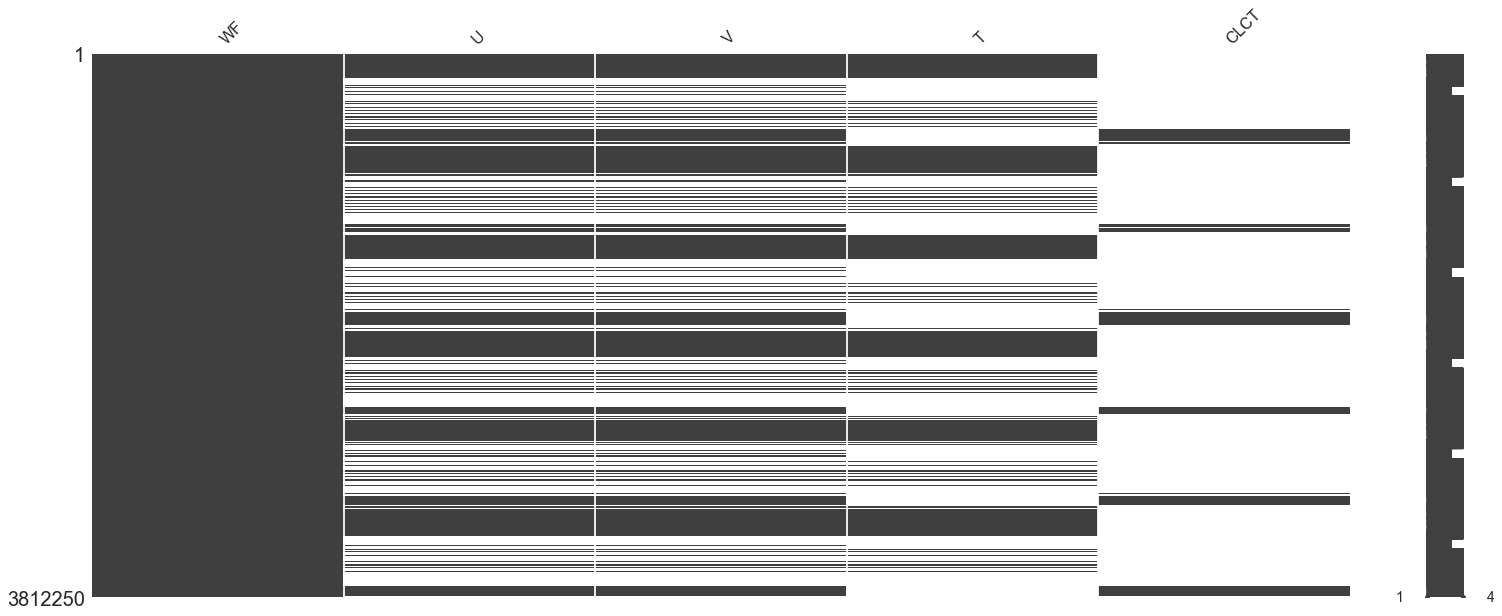

In [12]:
msno.matrix(df_eda[['WF','U','V','T','CLCT']])

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



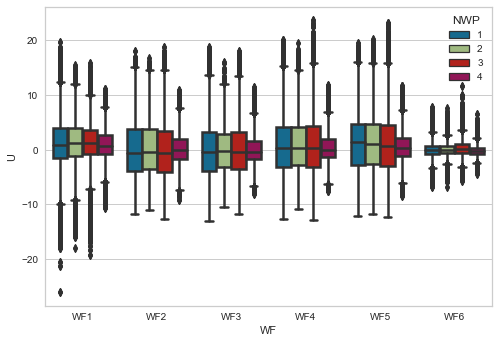

In [19]:
ax = sns.boxplot(x="WF", y="U", hue="NWP", data=df_eda, linewidth=2.5, )

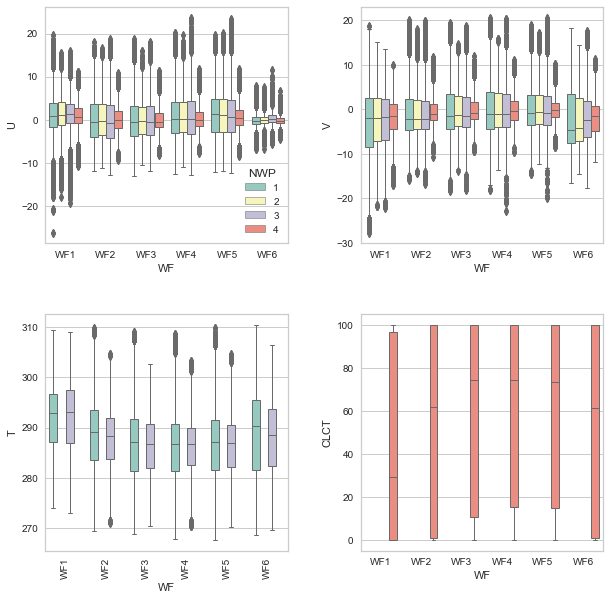

In [21]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.3, wspace=0.3,)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(x="WF", y="U", hue="NWP", data=df_eda, linewidth=1., palette="Set3")
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(x="WF", y="V", hue="NWP", data=df_eda, linewidth=1., palette="Set3" )
ax.get_legend().set_visible(False)
ax = fig.add_subplot(2, 2, 3)
sns.boxplot(x="WF", y="T", hue="NWP", data=df_eda, linewidth=1., palette="Set3")
ax.get_legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(x="WF", y="CLCT", hue="NWP", data=df_eda, linewidth=1., palette="Set3")
ax.get_legend().set_visible(False)

fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



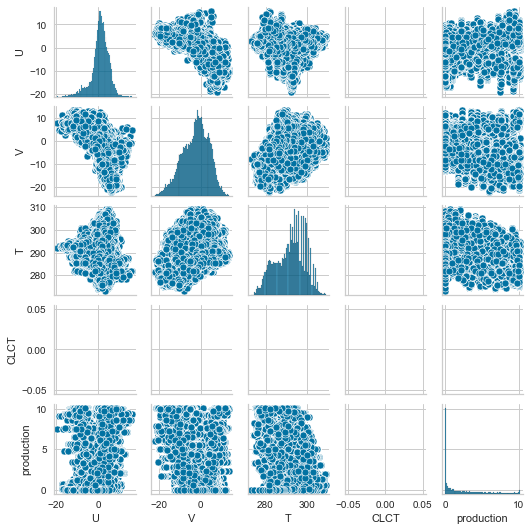

In [44]:
sns.pairplot(df_eda.loc[df_WF1['NWP'] == 3,['U','V','T','CLCT','production'], h], height=1.5)

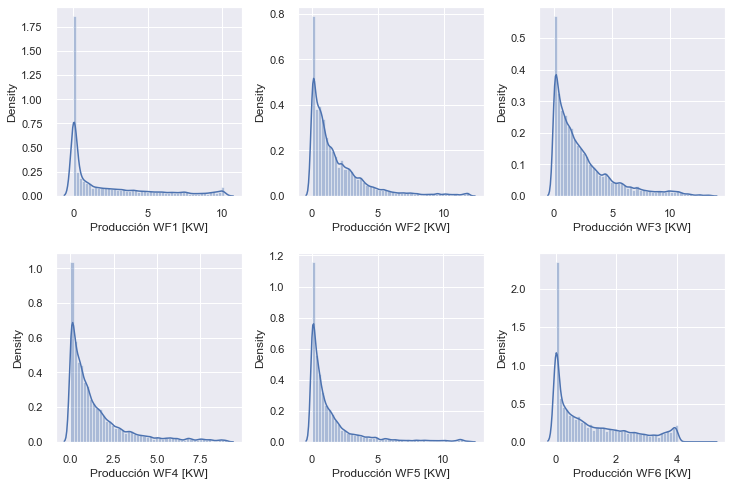

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from pylab import *

fig = plt.figure()
fig.subplots_adjust(hspace=0.3, wspace=0.3,)
sns.set(rc={"figure.figsize": (12, 8)});

subplot(2,3,1)
ax = sns.distplot(df_WF1['production'], axlabel="Producción WF1 [KW]")

subplot(2,3,2)
ax = sns.distplot(df_WF2['production'], axlabel="Producción WF2 [KW]")

subplot(2,3,3)
ax = sns.distplot(df_WF3['production'],axlabel="Producción WF3 [KW]")

subplot(2,3,4)
ax = sns.distplot(df_WF4['production'], axlabel="Producción WF4 [KW]")

subplot(2,3,5)
ax = sns.distplot(df_WF5['production'],axlabel="Producción WF5 [KW]")

subplot(2,3,6)
ax = sns.distplot(df_WF6['production'], axlabel="Producción WF6 [KW]")

plt.show()

In [31]:
df_WF1[["U","V","T","CLCT","production"]].head()

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,WF,time,NWP,fc_day,run,U,V,T,CLCT,production
0,WF1,01/05/2018 01:00,1,D-2,00h,NaN,NaN,NaN,NaN,0.02
1,WF1,01/05/2018 02:00,1,D-2,00h,NaN,NaN,NaN,NaN,0.07
2,WF1,01/05/2018 03:00,1,D-2,00h,NaN,NaN,NaN,NaN,0.22
3,WF1,01/05/2018 04:00,1,D-2,00h,NaN,NaN,NaN,NaN,0.39
4,WF1,01/05/2018 05:00,1,D-2,00h,NaN,NaN,NaN,NaN,0.41


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



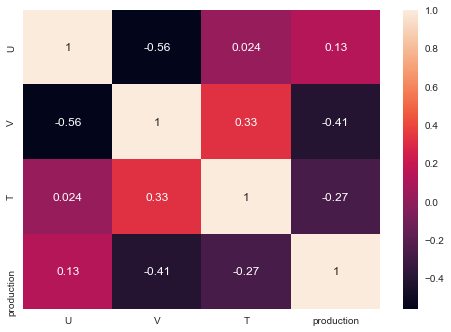

In [12]:
df_WF1[["U","V","T","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'

)

ax = sns.heatmap(df_WF1[["U","V","T","production"]].corr(), annot=True)

In [39]:
df_WF1[["U","V","T","CLCT","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'
)

df_WF2[["U","V","T","CLCT","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'
)

df_WF3[["U","V","T","CLCT","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'
)

df_WF4[["U","V","T","CLCT","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'
)

df_WF5[["U","V","T","CLCT","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'
)

df_WF6[["U","V","T","CLCT","production"]].corr().iplot(
    kind='heatmap', 
    colorscale='spectral',
    filename='cufflinks/simple-heatmap'
)